In [278]:
import numpy as np
np.random.seed(0)
from keras.models import load_model
from keras.layers import Input, LSTM, RepeatVector,GRU
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_fscore_support,accuracy_score,recall_score,confusion_matrix,precision_score,f1_score

import pandas as pd

from sklearn.svm import SVC

In [279]:
def print_metrics(Y,predictions):
    acc=accuracy_score(Y,predictions)
    war=recall_score(Y,predictions,average="weighted")
    wap=precision_score(Y,predictions,average="weighted")
    waf1=f1_score(Y,predictions,average="weighted")
    print("Accuracy: ",acc)
    print("Recall: ",war)
    print("Precision: ",wap)
    print("F1-Score: ",waf1)
    a=confusion_matrix(Y,predictions)
    print("{0:.2f}\t{1:.2f}\t{2:.2f}\t{3:.2f}".format(acc*100,war*100,wap*100,waf1*100))
    return a


In [334]:
TRAIN =False
SAVE_FEATURES=True
CELL_TYPE="gru"
timesteps=64
latent_dim=16
def save_features(file_names,X,Y,csv_file):
    df=pd.DataFrame(X)
    df["files"]=file_names
    df["Class"]=Y
    df.to_csv("features/"+csv_file+".csv",index=False)
    
def extract_features(db):
    train_db=pd.read_csv("spectograms/MeanNormalized/compare18-heartbeat-0.32-0.16-128-"+db+".csv/train/compare18-heartbeat-0.32-0.16-128-"+db+".csv")
    val_db=pd.read_csv("spectograms/MeanNormalized/compare18-heartbeat-0.32-0.16-128-"+db+".csv/devel/compare18-heartbeat-0.32-0.16-128-"+db+".csv")
    class0=train_db[train_db["label_nominal"]==0]
    class1=train_db[train_db["label_nominal"]==1]
    class2=train_db[train_db["label_nominal"]==2]
    
 
    train_upsampled=pd.concat((class0,class0,class0,class1,class2,class2))
    train_upsampled=train_upsampled.reindex()
    train_Y=train_upsampled.label_nominal
    val_Y=val_db.label_nominal
    train_X=train_upsampled.iloc[:,4:]
    val_X=val_db.iloc[:,4:]
    

    
    train_X=train_X.values.flatten().reshape(len(train_X),timesteps,372) #502,64,372
    input_dim=train_X.shape[2]
    
    inputs = Input(shape=(timesteps, input_dim))
    encoded = LSTM(latent_dim)(inputs)

    decoded = RepeatVector(timesteps)(encoded)
    decoded = LSTM(input_dim, return_sequences=True)(decoded)

    sequence_autoencoder = Model(inputs, decoded)
    
    encoder = Model(inputs, encoded) #hidden representations 
    if TRAIN:


        sequence_autoencoder.compile(optimizer='adam', loss='mse')
        early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
        sequence_autoencoder.fit(train_X,train_X,batch_size=32,epochs=150,callbacks=[early_stop])
        sequence_autoencoder.save("models/upsample/"+CELL_TYPE+"/autoencoder_2layer_"+str(timesteps)+"_"+db+"_"+str(latent_dim)+".model")

    else :
        sequence_autoencoder=load_model("models/upsample/"+CELL_TYPE+"/autoencoder_2layer_"+str(timesteps)+"_"+db+"_"+str(latent_dim)+".model")
    features_train_X=encoder.predict(train_X)
    features_val_X=encoder.predict(val_X.values.reshape(len(val_X),timesteps,372))
    if SAVE_FEATURES:
        save_features(train_upsampled.filename.values,features_train_X,train_Y.values,CELL_TYPE+"/upsample_2layer_"+str(timesteps)+"_"+db+"_"+str(latent_dim)+"train")
        save_features(val_db.filename.values,features_val_X,val_Y.values,CELL_TYPE+"/upsample_2layer_"+str(timesteps)+"_"+db+"_"+str(latent_dim)+"val")
    return features_train_X,features_val_X,train_Y,val_Y

In [335]:
train_75_X,val_75_X,train_75_Y,val_75_Y=extract_features("75")
train_60_X,val_60_X,train_60_Y,val_60_Y=extract_features("60")
train_45_X,val_45_X,train_45_Y,val_45_Y=extract_features("45")
train_30_X,val_30_X,train_30_Y,val_30_Y=extract_features("30")
# all Y's are same



In [312]:

train_X=np.concatenate((train_30_X,train_45_X,train_60_X,train_75_X),axis=1)
val_X=np.concatenate((val_30_X,val_45_X,val_60_X,val_75_X),axis=1)

In [313]:
train_Y.shape

(812, 3)

In [314]:

model = Sequential()
model.add(Dense(64, input_dim=4*latent_dim,activation="relu"))
model.add(Dense(64, activation="relu"))

model.add(Dense(3))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
train_Y=to_categorical(train_75_Y)
val_Y=to_categorical(val_30_Y)
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
model.fit(train_X,train_Y,batch_size=8,epochs=50,validation_data=(val_X, val_Y),callbacks=[early_stop])

predictions=np.argmax(model.predict(val_X),axis=1)
print_metrics(val_30_Y,predictions)

Train on 812 samples, validate on 180 samples
Epoch 1/50
812/812 [==============================] - 9s 11ms/step - loss: 1.1607 - acc: 0.3214 - val_loss: 1.1459 - val_acc: 0.3667
Epoch 2/50
812/812 [==============================] - 1s 701us/step - loss: 1.0892 - acc: 0.2660 - val_loss: 1.0896 - val_acc: 0.2167
Epoch 3/50
812/812 [==============================] - 1s 766us/step - loss: 1.1425 - acc: 0.2771 - val_loss: 1.3233 - val_acc: 0.2056
Epoch 4/50
812/812 [==============================] - 1s 784us/step - loss: 1.1042 - acc: 0.3030 - val_loss: 1.5755 - val_acc: 0.3444
Epoch 00004: early stopping
Accuracy:  0.34444444444444444
Recall:  0.34444444444444444
Precision:  0.3165403409406408
F1-Score:  0.31966091699837834
34.44	34.44	31.65	31.97


array([[13, 19,  0],
       [48, 49,  1],
       [26, 24,  0]], dtype=int64)

In [315]:

model = Sequential()
model.add(Dense(32, input_dim=latent_dim,activation="relu"))
model.add(Dense(32, input_dim=latent_dim,activation="relu"))

model.add(Dense(3))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
train_Y=to_categorical(train_75_Y)
val_Y=to_categorical(val_75_Y)
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
model.fit(train_75_X,train_Y,batch_size=8,epochs=50,validation_data=(val_75_X, val_Y),callbacks=[early_stop])

predictions=np.argmax(model.predict(val_75_X),axis=1)
print_metrics(val_30_Y,predictions)

Train on 812 samples, validate on 180 samples
Epoch 1/50
812/812 [==============================] - 9s 11ms/step - loss: 1.6417 - acc: 0.3091 - val_loss: 1.1209 - val_acc: 0.2389
Epoch 2/50
812/812 [==============================] - 1s 692us/step - loss: 1.1271 - acc: 0.2980 - val_loss: 1.3852 - val_acc: 0.2278
Epoch 3/50
812/812 [==============================] - 1s 697us/step - loss: 1.1204 - acc: 0.2796 - val_loss: 1.3981 - val_acc: 0.2111
Epoch 00003: early stopping
Accuracy:  0.2111111111111111
Recall:  0.2111111111111111
Precision:  0.34364811765423386
F1-Score:  0.2075288885677933
21.11	21.11	34.36	20.75


array([[15,  8,  9],
       [61, 12, 25],
       [33,  6, 11]], dtype=int64)

In [316]:
print_metrics(val_30_Y,predictions)

Accuracy:  0.2111111111111111
Recall:  0.2111111111111111
Precision:  0.34364811765423386
F1-Score:  0.2075288885677933
21.11	21.11	34.36	20.75


array([[15,  8,  9],
       [61, 12, 25],
       [33,  6, 11]], dtype=int64)

In [317]:
train_60_X.shape

(812, 16)

In [332]:

svm_model=SVC(C=10,kernel="rbf")
svm_model.fit(train_X,train_30_Y)
predictions=svm_model.predict(val_X)
accuracy_score
print_metrics(val_30_Y,predictions)

Accuracy:  0.37222222222222223
Recall:  0.37222222222222223
Precision:  0.40960219478737997
F1-Score:  0.3810541262212169
37.22	37.22	40.96	38.11


array([[ 5, 10, 17],
       [10, 43, 45],
       [ 7, 24, 19]], dtype=int64)

In [329]:

svm_model=SVC(C=10,kernel="rbf")
svm_model.fit(train_75_X,train_75_Y)
predictions=svm_model.predict(val_75_X)
accuracy_score
print_metrics(val_30_Y,predictions)

Accuracy:  0.4166666666666667
Recall:  0.4166666666666667
Precision:  0.4044160411171975
F1-Score:  0.402895552160258
41.67	41.67	40.44	40.29


array([[ 3, 19, 10],
       [ 4, 57, 37],
       [ 5, 30, 15]], dtype=int64)

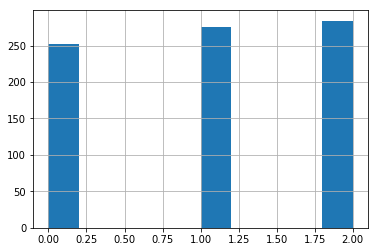

In [320]:
train_30_Y.hist()
plt.show()